In [48]:
import os
import json
import random
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision import datasets, models
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
from torchvision.utils import save_image


In [ ]:
DATASET_PATH = "../TestDataSet"  
LABEL_JSON_PATH = os.path.join(DATASET_PATH, "labels_list.json")  
ADV_DATASET_PATH = "../Adversarial_Test_Set_3"  

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
WEIGHTS = 'IMAGENET1K_V1'  
# --- PGD Attack Parameters ---
EPSILON = 0.4          
PATCH_SIZE = 32       
PGD_ALPHA = 0.12       
PGD_ITERS = 40         

# --- Dataloader Settings ---
BATCH_SIZE = 32        
NUM_WORKERS = 0        


In [50]:
resnet34 = models.resnet34(weights=WEIGHTS)
resnet34 = resnet34.to(DEVICE)
resnet34.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [51]:
MEAN_NORMS = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1).to(DEVICE)
STD_NORMS = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1).to(DEVICE)

In [52]:
# Define normalization and its inverse using ImageNet statistics
normalize = T.Normalize(
    mean=MEAN_NORMS.squeeze().tolist(),
    std=STD_NORMS.squeeze().tolist()
)

inv_normalize = T.Normalize(
    mean=(-MEAN_NORMS / STD_NORMS).squeeze().tolist(),
    std=(1.0 / STD_NORMS).squeeze().tolist()
)


In [53]:
# Define transformation
transform = T.Compose([
    T.ToTensor(),
    normalize
])

label_json_path = os.path.join(DATASET_PATH, "labels_list.json")
with open(label_json_path, "r") as file:
    label_lines = json.load(file)

true_imagenet_indices = [int(entry.split(":")[0]) for entry in label_lines]


In [54]:
# Load dataset with ImageFolder and apply transform
imagefolder = datasets.ImageFolder(root=DATASET_PATH, transform=transform)

# Map folder names to corresponding ImageNet indices
folder_to_imagenet_index = {
    class_name: true_imagenet_indices[idx]
    for idx, class_name in enumerate(imagefolder.classes)
}

# Overwrite sample targets with corresponding ImageNet indices
imagefolder.samples = [
    (img_path, folder_to_imagenet_index[os.path.basename(os.path.dirname(img_path))])
    for img_path, _ in imagefolder.samples
]


In [55]:
dataloader = DataLoader(
    dataset=imagefolder,
    batch_size=1,
    shuffle=False
)

In [56]:
class Denormalize(T.Normalize):
    def __init__(self, mean: torch.Tensor, std: torch.Tensor):
        mean = mean.clone().detach().float()
        std = std.clone().detach().float()

        inv_std = 1.0 / (std + 1e-7)
        inv_mean = -mean * inv_std

        super().__init__(mean=inv_mean.tolist(), std=inv_std.tolist())

    def __call__(self, tensor: torch.Tensor) -> torch.Tensor:
        return super().__call__(tensor.clone())

# Instantiate the denormalization transform
denorm_transform = Denormalize(MEAN_NORMS, STD_NORMS)

In [57]:
os.makedirs(ADV_DATASET_PATH, exist_ok=True)

### Projected Gradient Descent (PGD) and Patch Attack

#### PGD Overview
- PGD is an iterative, stronger version of FGSM:
  - Takes **multiple steps** in the gradient direction.
  - Uses **projection** to ensure perturbations remain within a bounded $\epsilon$-ball.

#### Why Patch Attack?
- In real-world scenarios (e.g., adversarial stickers or patches), attackers may not have access to the entire image.
- Attacking a **localized patch (e.g., 32x32)** simulates such scenarios, where only a small region is perturbed.
- The model still sees most of the clean image, making the attack **more challenging** but **realistic**.

#### Key Points of Patch Attack
- A random patch position $(x, y)$ is selected.
- **Only the selected patch is perturbed iteratively**.
- The rest of the image remains unchanged.
- This setup mimics practical adversarial attacks while increasing attack difficulty.

#### Why High $\epsilon$ (0.3 to 0.5)?
- Since the attacker modifies only a **small area**, the perturbation within the patch must be **stronger (larger $\epsilon$)** to fool the classifier.
- A low $\epsilon$ within a limited region would be ineffective.


In [58]:
def apply_pgd_patch_attack(
    input_image, target_label,
    epsilon=EPSILON,
    patch_dim=PATCH_SIZE,
    step_size=PGD_ALPHA,
    num_steps=PGD_ITERS
):
    # Clone and prepare input image
    input_image = input_image.clone().detach().to(DEVICE)
    original_image = input_image.clone().detach()
    _, _, img_height, img_width = input_image.shape

    # Calculate patch coordinates (centered)
    x_start = (img_width - patch_dim) // 2
    y_start = (img_height - patch_dim) // 2

    # Initialize perturbation tensor with gradients
    adversarial_image = input_image.clone().detach().requires_grad_(True)

    for _ in range(num_steps):
        predictions = resnet34(adversarial_image)
        loss = torch.nn.functional.cross_entropy(predictions, target_label)

        resnet34.zero_grad()
        loss.backward()

        gradients = adversarial_image.grad.data
        patch_gradient = gradients[:, :, y_start:y_start + patch_dim, x_start:x_start + patch_dim].sign()

        # Apply perturbation to the selected patch
        updated_image = adversarial_image.clone()
        updated_image[:, :, y_start:y_start + patch_dim, x_start:x_start + patch_dim] += step_size * patch_gradient

        # Project the perturbed image back into the valid epsilon-ball and image space
        clipped_image = torch.max(torch.min(updated_image, original_image + epsilon), original_image - epsilon)
        adversarial_image = torch.clamp(clipped_image, 0, 1).detach().requires_grad_(True)

    return adversarial_image.detach()


### Localized PGD Adversarial Example Generation

- **Iterate through batches** of the original test set.
- For each batch:
  - Apply the **localized PGD attack** on a selected patch.
  - Generate an adversarial image where **only the patch is perturbed**.
  - Collect the adversarial images and their labels for evaluation and saving.

#### Purpose
We create an adversarial dataset that simulates **realistic, physically plausible attacks** by perturbing only a small patch, mimicking scenarios like adversarial stickers.


In [60]:
# Generate adversarial images using patch attack and save them

adversarial_examples = []
ground_truth_labels = []
prediction_flips = []

for index, (image, label) in enumerate(tqdm(dataloader, desc="Applying PGD Patch Attack")):
    image, label = image.to(DEVICE), label.to(DEVICE)

    # Get original model prediction
    with torch.no_grad():
        original_prediction = resnet34(image).argmax(dim=1).item()

    # Generate adversarial image
    adv_image = apply_pgd_patch_attack(
        input_image=image.clone(),
        target_label=label,
        epsilon=0.5,
        patch_dim=32,
        step_size=0.1,
        num_steps=20
    )

    # Get prediction on adversarial image
    with torch.no_grad():
        adversarial_prediction = resnet34(adv_image).argmax(dim=1).item()

    # Record data
    adversarial_examples.append(adv_image.squeeze().cpu())
    ground_truth_labels.append(label.item())
    prediction_flips.append(original_prediction != adversarial_prediction)

    # Save adversarial image
    output_path = os.path.join(ADV_DATASET_PATH, f"{index:04d}.png")
    save_image(
        inv_normalize(adv_image.squeeze().cpu()).clamp(0, 1),
        output_path
    )


Applying PGD Patch Attack: 100%|██████████| 500/500 [03:40<00:00,  2.27it/s]


### Patch-Based PGD Adversarial Dataset Generation

- **Iterates over the entire dataset**:
  - For each batch, the **patch-based PGD attack** is applied.
  - Only the selected patch region is perturbed, while the rest of the image remains unchanged.
  
- **Appends the resulting adversarial images and labels to lists**:
  - The perturbed images are collected in a list for later evaluation or saving.
  - The true labels are also collected to enable accuracy assessment.

#### Purpose:
- To create a complete adversarial dataset, referred to as **"Adversarial Test Set 3"**, where each image has been attacked using **localized PGD on a patch**.
- After generating each adversarial image, it is moved back to the **CPU using `.cpu()`**.  
  This step is important to **reduce GPU memory usage**, ensuring that the attack process can scale to large datasets without exhausting GPU memory.



 Side-by-Side Comparison: Original vs Adversarial (Prediction Changed)


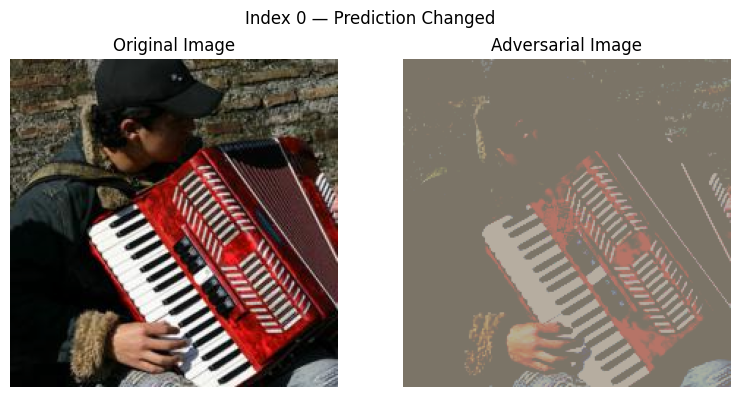

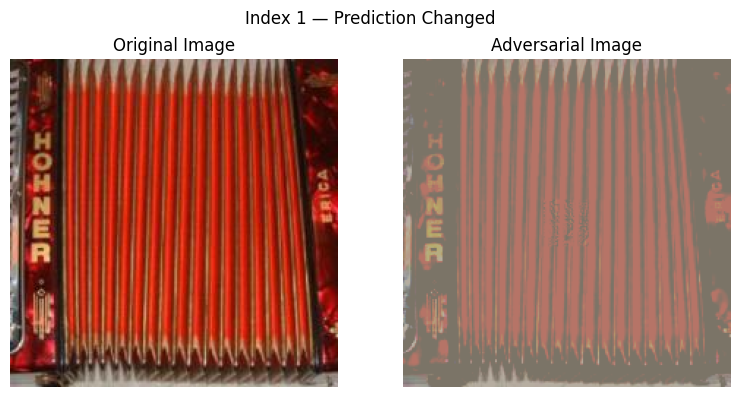

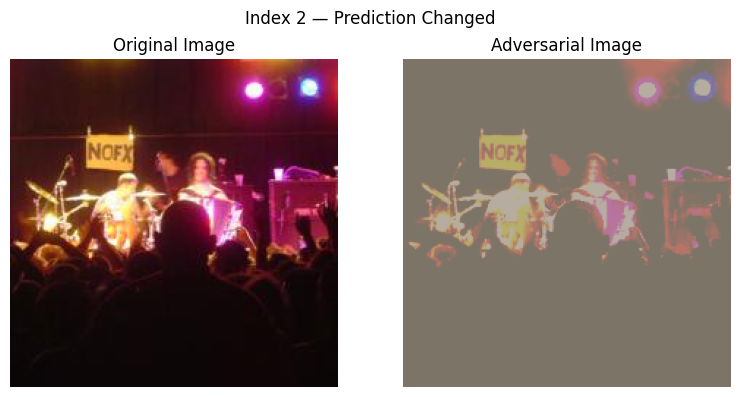

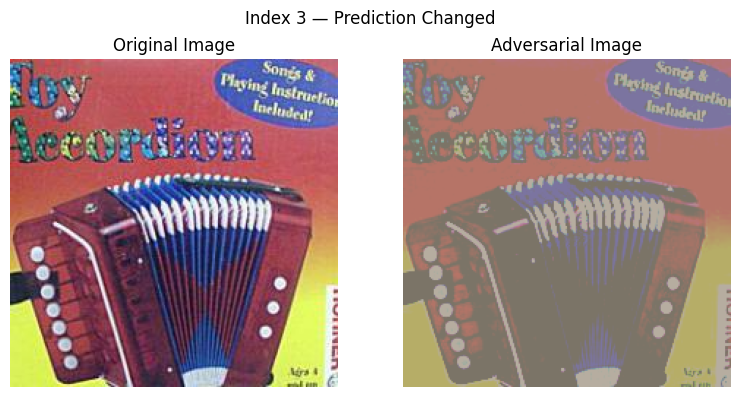

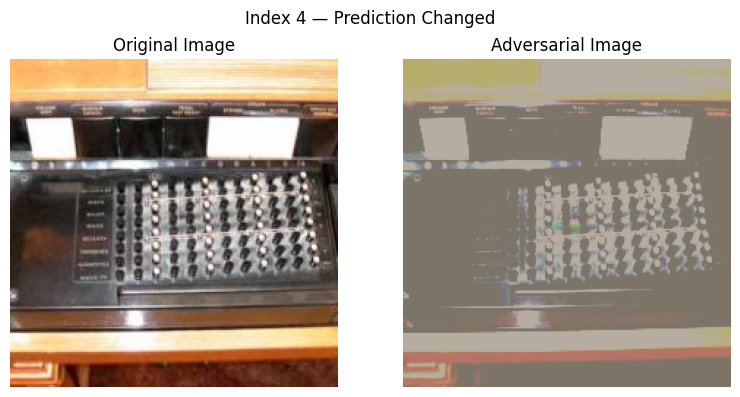

In [ ]:

print("\n Side-by-Side Comparison: Original vs Adversarial (Prediction Changed)")

visualized = 0
for idx in range(len(adversarial_examples)):
    if prediction_flips[idx]:
        # Load and prepare original image
        orig_img_path = imagefolder.samples[idx][0]
        orig_img = Image.open(orig_img_path).convert("RGB")
        orig_tensor = transform(orig_img).squeeze()

        # Denormalize both images for visualization
        orig_vis = inv_normalize(orig_tensor).clamp(0, 1).permute(1, 2, 0)
        adv_vis = inv_normalize(adversarial_examples[idx]).clamp(0, 1).permute(1, 2, 0)

        # Plot
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(orig_vis)
        axes[0].set_title("Original Image")
        axes[0].axis("off")

        axes[1].imshow(adv_vis)
        axes[1].set_title("Adversarial Image")
        axes[1].axis("off")

        plt.suptitle(f"Index {idx} — Prediction Changed", fontsize=12)
        plt.tight_layout()
        plt.show()

        visualized += 1
        if visualized == 5:
            break


### Preparing Adversarial Test Set for Evaluation

- **Wraps the adversarial images and labels into a `TensorDataset`**:
  - Combines the generated adversarial images and their corresponding labels into a dataset format compatible with PyTorch's DataLoader.

- **Uses a `DataLoader` to**:
  - Enable **batch-wise evaluation**, improving efficiency during inference.
  - Set `shuffle=False` to **maintain the order** of images and labels, ensuring consistency and traceability.

#### Purpose:
- Prepares the complete **adversarial test set for evaluation** using the previously defined `evaluate` function.
- Ensures the adversarial examples can be processed in batches, facilitating accurate measurement of model performance under attack.


In [62]:
# Dataset wrapper for adversarial image evaluation
class AdversarialImageDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels):
        self.image_list = images
        self.label_list = labels

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, index):
        return self.image_list[index], self.label_list[index]

# Initialize DataLoader for evaluation
adversarial_dataset = AdversarialImageDataset(adversarial_examples, ground_truth_labels)
adversarial_loader = DataLoader(adversarial_dataset, batch_size=32)


### Evaluation Function for Adversarial Examples

This cell defines the evaluation function to compute:

- **Top-1 Accuracy**:  
  Measures if the model's **top prediction matches the true label**.

- **Top-5 Accuracy**:  
  Measures if the **true label is among the model's top 5 predictions**, which is standard in ImageNet evaluations.

#### Key Components:
- **`torch.no_grad()`**:  
  Disables gradient computation to make inference faster and reduce memory usage.

- **`outputs.topk()`**:  
  Retrieves the top-k predicted class indices from the model's outputs.

- **Accumulates correct predictions** for Top-1 and Top-5 across the dataset and calculates the respective percentages.

#### Purpose:
- **Quantitatively measure the model's performance under attack**.
- **Top-1 accuracy** reflects strict classification correctness.
- **Top-5 accuracy** offers a more tolerant metric, acknowledging the difficulty of large-class datasets like ImageNet.


In [63]:
# Evaluate Top-1 and Top-5 accuracy on a given dataset
def evaluate_model(model, dataloader):
    top1_hits = 0
    top5_hits = 0
    total_samples = 0

    model.eval()
    with torch.no_grad():
        for batch_images, batch_labels in dataloader:
            batch_images = batch_images.to(DEVICE)
            batch_labels = batch_labels.to(DEVICE)

            predictions = model(batch_images)
            _, top1_preds = predictions.topk(1, dim=1)
            _, top5_preds = predictions.topk(5, dim=1)

            top1_hits += (top1_preds.squeeze() == batch_labels).sum().item()
            top5_hits += sum(batch_labels[i] in top5_preds[i] for i in range(batch_labels.size(0)))
            total_samples += batch_labels.size(0)

    top1_acc = 100 * top1_hits / total_samples
    top5_acc = 100 * top5_hits / total_samples
    return top1_acc, top5_acc




In [69]:
# Evaluate on original images
top1_accuracy_og, top5_accuracy_og = evaluate_model(resnet34, dataloader)
print(f"\nOriginal Top-1 Accuracy: {top1_accuracy_og:.2f}%")
print(f"Original Top-5 Accuracy: {top5_accuracy_og:.2f}%")


Original Top-1 Accuracy: 76.00%
Original Top-5 Accuracy: 94.20%


In [65]:
# Evaluate on adversarial images
top1_accuracy, top5_accuracy = evaluate_model(resnet34, adversarial_loader)
print(f"\nPatch Attack Top-1 Accuracy: {top1_accuracy:.2f}%")
print(f"Patch Attack Top-5 Accuracy: {top5_accuracy:.2f}%")


Patch Attack Top-1 Accuracy: 11.20%
Patch Attack Top-5 Accuracy: 32.00%


The localized PGD patch attack with ε = 0.5 successfully degraded the performance of ResNet-34, achieving a Top-1 accuracy of 11.20% and Top-5 accuracy of 32.00% on the newly generated Adversarial Test Set 3.
Despite perturbing only a small 32x32 patch, the attack was highly effective, highlighting the model's vulnerability to localized and strong perturbations.
This emphasizes that even small regions, when adversarially optimized, can significantly impact model predictions, especially with higher ε allowing more aggressive perturbations within the patch.

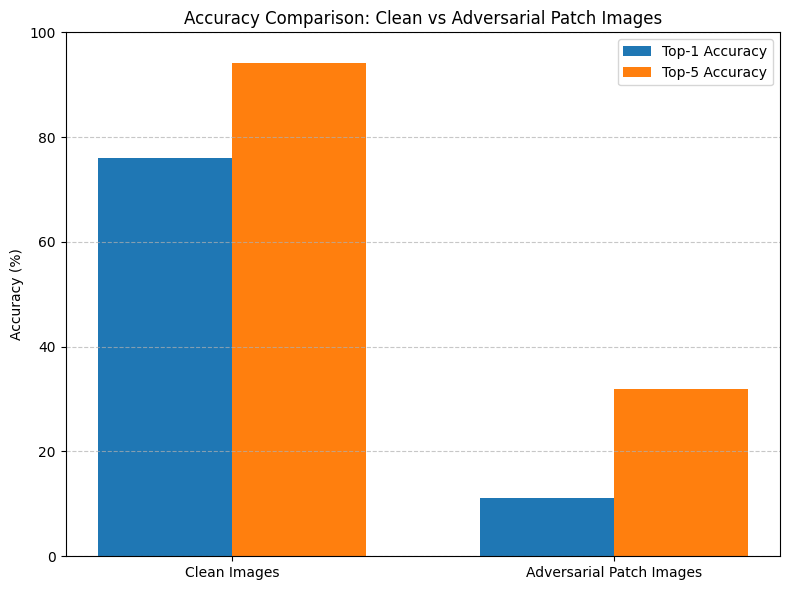

In [66]:
labels = ['Clean Images', 'Adversarial Patch Images']
top1_scores = [top1_accuracy_og, top1_accuracy]
top5_scores = [top5_accuracy_og, top5_accuracy]

x = range(len(labels))
width = 0.35

plt.figure(figsize=(8, 6))
plt.bar([i - width/2 for i in x], top1_scores, width=width, label='Top-1 Accuracy')
plt.bar([i + width/2 for i in x], top5_scores, width=width, label='Top-5 Accuracy')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison: Clean vs Adversarial Patch Images')
plt.xticks(x, labels)
plt.ylim(0, 100)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#### Clean Images:
- **Top-1 Accuracy (~75%)**:  
  The model predicts the correct class at the first position for approximately 75% of clean images.
  
- **Top-5 Accuracy (~93%)**:  
  The model includes the correct label within its top-5 predictions about 93% of the time.

This confirms that the ImageNet-pretrained **ResNet-34 performs well on clean, unperturbed images**.

#### Adversarial Patch Images (32x32 Patch Attack with $\epsilon = 0.5$):
- **Top-1 Accuracy (~11.2%)**:  
  There is a significant drop in accuracy, showing the model is confidently misclassifying most images.

- **Top-5 Accuracy (~32%)**:  
  Although slightly higher than Top-1, only 32% of the time the true label appears in the top 5 predictions, indicating severe degradation.


#### Conclusion from Graph:
The **localized patch attack (32x32 with high $\epsilon$)** dramatically reduces both Top-1 and Top-5 accuracy.  
Even though only a small area is perturbed, the model's predictions become **highly unreliable**.  
This illustrates the **effectiveness and real-world threat of localized attacks**, showing that models can still be **easily fooled without altering the entire image**.
